In [1]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
np.random.seed(int(np.pi*10**5)) # Don't be too random on the test suit!

In [3]:
from keras.models import Sequential, Model

Using TensorFlow backend.


In [4]:
from keras.layers import Dense, GRU, LSTM
from keras.layers import Input, TimeDistributed, Embedding, RepeatVector, Lambda, Bidirectional
from keras.layers import Flatten, Reshape, Permute, Activation
from keras.layers import Dot, Concatenate, Multiply
from keras.layers import merge
from keras.callbacks import EarlyStopping
from keras import backend as K

## Preprocessing

Process the text and find the vocabulary size for source input language + create one-hot vectors for all words in target language

In [5]:
src_word_chunker = lambda sent: list(sent)
trg_word_chunker = lambda sent: list(sent)

# depending on the preprocessing that we need we might need different word chunching functions
#src_word_chunker = lambda sent: sent.split()
#trg_word_chunker = lambda sent: sent.split()

#### Read from synthetic tree translation

In [6]:
source, target = [], []
src_vocab, trg_vocab = set({}), set({})
src_max_len = 1
trg_max_len = 1
with open('synthtrees.txt', 'r') as sythtree:
    for line in sythtree:
        src_sent_raw, trg_sent_raw = line.strip().split('\t')

        src_sent = src_word_chunker(src_sent_raw)
        trg_sent = trg_word_chunker(trg_sent_raw)

        # add to the list (chunked)
        source.append(src_sent)
        target.append(trg_sent)
        
        # update vocabulary with new words
        src_vocab.update(src_sent)
        trg_vocab.update(trg_sent)
        
        src_max_len   = src_max_len if src_max_len > len(src_sent) else len(src_sent)
        trg_max_len   = trg_max_len if trg_max_len > len(src_sent) else len(src_sent)
        
# the first words is the padding sign:
src_vocab = ['<s>'] + list(src_vocab)
trg_vocab = ['<s>'] + list(trg_vocab)

src_vocab_size = len(src_vocab)
trg_vocab_size = len(trg_vocab)

# convert words to word_id 
source_sents = [ 
    [src_vocab.index(w) for w in sent]
    for sent in source
]

target_sents = [ 
    [trg_vocab.index(w) for w in sent]
    for sent in target
]





#### General preprocessing

In [7]:
# fixed length of source and target inputs after padding
T_x = src_max_len
T_y = trg_max_len + 1

from keras.preprocessing import sequence

# padded sentences
# https://keras.io/preprocessing/sequence/
source_pp = sequence.pad_sequences(source_sents, maxlen=T_x)
target_pp = sequence.pad_sequences(sequence.pad_sequences(target_sents, maxlen=T_y-1), maxlen=T_y)
trg_end_padding = np.pad(target_pp[:,1:], [(0,0), (0,1)], 'constant', constant_values=0)



In [8]:
print("source vocab size:", src_vocab_size)
print("target vocab size:", trg_vocab_size)

print('source shape:', source_pp.shape)
print('target shape:', target_pp.shape)

source vocab size: 13
target vocab size: 13
source shape: (10000, 21)
target shape: (10000, 22)


## Models

#### Usefull functions

In [9]:
def one_hot_initializer(shape, dtype=None):
    """Keras friendly initialization for one-hot encodedings as embedings"""
    output = K.eye(shape[0], dtype=dtype)
    output = K.concatenate([K.zeros_like(output[:1,:]), output[1:,:]], 0)
    output = K.concatenate([K.zeros_like(output[:,:1]), output[:,1:]], 1)
    return output

def sequential_layer_composition(input_tensor, layers):
    """This function takes a list of layers similar to Sequential but it is designed to work for Model in Keras"""
    if len(layers) > 1:
        return sequential_layer_composition(layers[0](input_tensor), layers[1:])
    else:
        return layers[0](input_tensor)


#### Encoder

In [10]:
encoder_unit_size = 32
encoder_embedding_size = 8
#encoder_embedding_size = src_vocab_size

In [11]:
# the length of source and target inputs can be different but I chose the same max_len=10
src_input = Input(shape=(T_x,))
trg_input = Input(shape=(T_y,)) # +1 for initial padding

In [12]:
source_embeddings = Embedding(
    src_vocab_size,
    encoder_embedding_size,
    input_shape=(T_x,),
    #embeddings_initializer=one_hot_initializer,
    #trainable=False,
)

encoder_model = Sequential([
    source_embeddings, 
    Bidirectional(LSTM(int(encoder_unit_size/2), return_sequences=True)),
    Bidirectional(LSTM(int(encoder_unit_size/2), return_sequences=True)),
])

In [13]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 8)             104       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 32)            3200      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 32)            6272      
Total params: 9,576
Trainable params: 9,576
Non-trainable params: 0
_________________________________________________________________


In [14]:
encoder_output = encoder_model(src_input)


### Decoder + Attention

In [15]:
decoder_unit_size = 32
decoder_embedding_size = 8
#decoder_embedding_size = trg_vocab_size

#### Attention Model 

In [16]:
# Understanding the following code require both understanding the desgin, some math behind it, and Keras tricks.
m = T_x # source lenth
n = T_y # target lenth
d1 = encoder_unit_size
d2 = decoder_unit_size

# concatenate all H = (h_i) to all S = (s_j) ===> H_S = [s_(j-1) h_i] (S lag one phase behind)
S          = Input((n, d2,))
S_shift    = Lambda(lambda x: K.concatenate([K.zeros_like(K.expand_dims(x[:,0], 1)), x[:,:-1]], 1))(S)
S_flat     = Flatten()(S_shift)
S_flat_rep = RepeatVector(m)(S_flat)
S_rep_n    = Reshape((m, n, d2))(S_flat_rep)
# (m, n, d2,)

H            = Input((m, d1,))
H_flat       = Flatten()(H)
H_flat_rep   = RepeatVector(n)(H_flat)
H_flat_rep_  = Reshape((n, m, d1))(H_flat_rep)
H_rep_m      = Permute((2,1,3))(H_flat_rep_) 
# (m, n, d1,)

# concatenate everything with everything:
S_H_     = Concatenate(-1)([S_rep_n, H_rep_m]) 
# (m, n, d1+d2)
S_H_flat = Flatten()(S_H_)
S_H      = Reshape((m*n, (d1+d2)))(S_H_flat) 
# (m*n, (d1+d2),)

# make the e_ji
E_T_1 = TimeDistributed(Dense(d1+d2, activation='tanh'))(S_H)
E_T_  = TimeDistributed(Dense(1, activation='linear'))(E_T_1)
E_T   = Reshape((m, n))(E_T_) 
E     = Permute((2,1))(E_T) # E = {E_j} = {{ e_{ji} }} 
# (n, m,)

# the alignemtns
alpha = TimeDistributed(Activation('softmax'))(E) # alpha_j = softmax(E_j}
# (n, m,)

C     = Dot((2,1))([alpha, H])
# (n, d1,)

attention_model = Model([S, H], C)


#### Decoder layers

In [17]:
target_embeddings = Embedding(
    trg_vocab_size,
    decoder_embedding_size,
    input_shape=(T_y,),
    #embeddings_initializer=one_hot_initializer,
    #trainable=False,
)
decoder_rnn = LSTM(decoder_unit_size, return_sequences=True, input_shape=(T_y, decoder_embedding_size+encoder_unit_size))

decoder_model = Model(
    [src_input, trg_input],
    sequential_layer_composition(trg_input, [
        target_embeddings, 
        decoder_rnn, 
        lambda S: Concatenate(2)([S, attention_model([S, encoder_output])]),
        TimeDistributed(Dense(trg_vocab_size, activation='softmax')),
    ])
)

alignments_model = Model(
    [src_input, trg_input],
    sequential_layer_composition(trg_input, [
        target_embeddings,
        decoder_rnn, 
        lambda x: Model([S, H], alpha)([x, encoder_output]),
    ])
)

#### Decoder summary

In [18]:
decoder_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 22)            0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 22, 8)         104         input_2[0][0]                    
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 21)            0                                            
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 22, 32)        5248        embedding_2[0][0]                
___________________________________________________________________________________________

### Finishing structure

In [19]:
# input of the encoder-decoder model is a list of two inputs: source, target
encoder_decoder = Model([src_input, trg_input], decoder_model([src_input, trg_input]))

In [20]:
encoder_decoder.compile('adam', 'categorical_crossentropy')

In [21]:
encoder_decoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 21)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 22)            0                                            
____________________________________________________________________________________________________
model_2 (Model)                  (None, 22, 13)        19998       input_1[0][0]                    
                                                                   input_2[0][0]                    
Total params: 19,998
Trainable params: 19,998
Non-trainable params: 0
____________________________________________________________________________________________________


## Training

In [22]:
encoder_decoder.fit(
    x          = [source_pp, target_pp],
    y          = np.eye(trg_vocab_size)[trg_end_padding],
    batch_size = 300,
    epochs     = 1000,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10)],
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
8000/8000 [==============================] - 13s - loss: 2.3978 - val_loss: 2.0210
Epoch 2/1000
8000/8000 [==============================] - 4s - loss: 1.7828 - val_loss: 1.6616
Epoch 3/1000
8000/8000 [==============================] - 4s - loss: 1.6058 - val_loss: 1.5618
Epoch 4/1000
8000/8000 [==============================] - 4s - loss: 1.4731 - val_loss: 1.3558
Epoch 5/1000
8000/8000 [==============================] - 4s - loss: 1.2626 - val_loss: 1.1747
Epoch 6/1000
8000/8000 [==============================] - 4s - loss: 1.1061 - val_loss: 1.0401
Epoch 7/1000
8000/8000 [==============================] - 4s - loss: 0.9918 - val_loss: 0.9424
Epoch 8/1000
8000/8000 [==============================] - 4s - loss: 0.9066 - val_loss: 0.8690
Epoch 9/1000
8000/8000 [==============================] - 4s - loss: 0.8478 - val_loss: 0.8263
Epoch 10/1000
8000/8000 [==============================] - 4s - loss: 0.8078 - val_loss: 0.7900


8000/8000 [==============================] - 4s - loss: 0.2280 - val_loss: 0.2378
Epoch 170/1000
8000/8000 [==============================] - 4s - loss: 0.2270 - val_loss: 0.2295
Epoch 171/1000
8000/8000 [==============================] - 4s - loss: 0.2238 - val_loss: 0.2273
Epoch 172/1000
8000/8000 [==============================] - 4s - loss: 0.2227 - val_loss: 0.2265
Epoch 173/1000
8000/8000 [==============================] - 4s - loss: 0.2206 - val_loss: 0.2246
Epoch 174/1000
8000/8000 [==============================] - 4s - loss: 0.2188 - val_loss: 0.2234
Epoch 175/1000
8000/8000 [==============================] - 4s - loss: 0.2173 - val_loss: 0.2210
Epoch 176/1000
8000/8000 [==============================] - 4s - loss: 0.2151 - val_loss: 0.2193
Epoch 177/1000
8000/8000 [==============================] - 4s - loss: 0.2150 - val_loss: 0.2196
Epoch 178/1000
8000/8000 [==============================] - 4s - loss: 0.2127 - val_loss: 0.2165
Epoch 179/1000
8000/8000 [===================

8000/8000 [==============================] - 4s - loss: 0.0480 - val_loss: 0.0600
Epoch 338/1000
8000/8000 [==============================] - 4s - loss: 0.0479 - val_loss: 0.0598
Epoch 339/1000
8000/8000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0594
Epoch 340/1000
8000/8000 [==============================] - 4s - loss: 0.0467 - val_loss: 0.0587
Epoch 341/1000
8000/8000 [==============================] - 4s - loss: 0.0460 - val_loss: 0.0578
Epoch 342/1000
8000/8000 [==============================] - 4s - loss: 0.0452 - val_loss: 0.0579
Epoch 343/1000
8000/8000 [==============================] - 4s - loss: 0.0446 - val_loss: 0.0565
Epoch 344/1000
8000/8000 [==============================] - 4s - loss: 0.0444 - val_loss: 0.0567
Epoch 345/1000
8000/8000 [==============================] - 4s - loss: 0.0440 - val_loss: 0.0568
Epoch 346/1000
8000/8000 [==============================] - 4s - loss: 0.0438 - val_loss: 0.0555
Epoch 347/1000
8000/8000 [===================

8000/8000 [==============================] - 4s - loss: 0.0047 - val_loss: 0.0149
Epoch 506/1000
8000/8000 [==============================] - 4s - loss: 0.0046 - val_loss: 0.0148
Epoch 507/1000
8000/8000 [==============================] - 4s - loss: 0.0044 - val_loss: 0.0146
Epoch 508/1000
8000/8000 [==============================] - 4s - loss: 0.0043 - val_loss: 0.0149
Epoch 509/1000
8000/8000 [==============================] - 4s - loss: 0.0042 - val_loss: 0.0145
Epoch 510/1000
8000/8000 [==============================] - 4s - loss: 0.0041 - val_loss: 0.0143
Epoch 511/1000
8000/8000 [==============================] - 4s - loss: 0.0041 - val_loss: 0.0144
Epoch 512/1000
8000/8000 [==============================] - 4s - loss: 0.0040 - val_loss: 0.0142
Epoch 513/1000
8000/8000 [==============================] - 4s - loss: 0.0039 - val_loss: 0.0141
Epoch 514/1000
8000/8000 [==============================] - 4s - loss: 0.0038 - val_loss: 0.0141
Epoch 515/1000
8000/8000 [===================

8000/8000 [==============================] - 4s - loss: 3.0515e-04 - val_loss: 0.0105
Epoch 672/1000
8000/8000 [==============================] - 4s - loss: 2.9818e-04 - val_loss: 0.0106
Epoch 673/1000
8000/8000 [==============================] - 4s - loss: 2.9215e-04 - val_loss: 0.0104
Epoch 674/1000
8000/8000 [==============================] - 4s - loss: 2.8666e-04 - val_loss: 0.0103
Epoch 675/1000
8000/8000 [==============================] - 4s - loss: 2.8311e-04 - val_loss: 0.0105
Epoch 676/1000
8000/8000 [==============================] - 4s - loss: 2.8475e-04 - val_loss: 0.0104
Epoch 677/1000
8000/8000 [==============================] - 4s - loss: 2.8411e-04 - val_loss: 0.0103
Epoch 678/1000
8000/8000 [==============================] - 4s - loss: 2.8107e-04 - val_loss: 0.0101
Epoch 679/1000
8000/8000 [==============================] - 4s - loss: 2.6768e-04 - val_loss: 0.0102
Epoch 680/1000
8000/8000 [==============================] - 4s - loss: 2.6502e-04 - val_loss: 0.0103
Epoch

## Investigations

In [23]:
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

#### Visualising the alignments

In [24]:
#test_srcs = source_pp[929:]
#test_trgs = target_pp[929:]
test_srcs = source_pp[8000:]
test_trgs = target_pp[8000:]
#test_srcs = source_pp[7666:]
#test_trgs = target_pp[7666:]


#test_srcs = np.array([[0,0,0,0,0,0,0,0,1,2]])
#test_trgs = np.array([[0,0,0,0,0,0,0,0,0,2,1]])

alphas = alignments_model.predict([
    test_srcs,
    test_trgs,
])


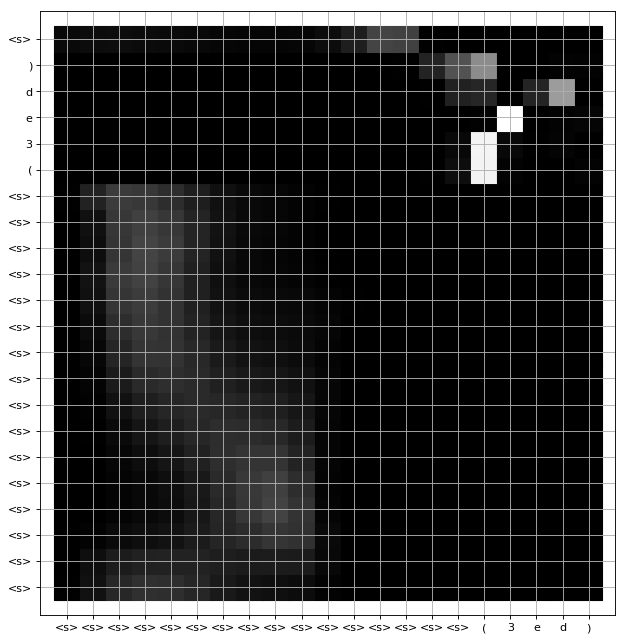

In [25]:
i = 203
plt.gray()
fig = plt.figure(figsize=(10, 10), dpi= 80)
ax  = plt.subplot(111, aspect='equal')
ax.scatter(
    np.tile(np.arange(T_x), T_y),
    np.tile(np.arange(T_y), (T_x,1)).T.reshape(T_y*T_x),
    s=560,
    marker='s',
    c=(alphas[i].flatten())
)
ax.set_xticks(np.arange(T_x))
ax.set_yticks(np.arange(T_y))
ax.set_xticklabels(np.array(src_vocab)[test_srcs[i]])
ax.set_yticklabels(np.array(trg_vocab)[np.concatenate([test_trgs[i][1:], np.array([0])])])
#ax.gray()

plt.grid()
plt.show()
